# Analysis on the effects of modeling and training decisions for greener computer vision systems

Author: Santiago del Rey

## Import libraries

In [126]:
import os

import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikit_posthocs as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from cliffs_delta import cliffs_delta
from scipy import stats
from statsmodels.formula.api import ols

from environment import FIGURES_DIR, OUTPUT_DIR, DATA_DIR

%matplotlib inline

mlp.rcParams["font.family"] = "serif"
mlp.rcParams["font.serif"] = "Times New Roman"
mlp.rcParams["font.size"] = 8
mlp.rcParams["figure.autolayout"] = "true"

SAVE_FIGS = True

## Load the dataset

In [127]:
analysis_df = pd.read_parquet(
    os.path.join(DATA_DIR, "processed", "dl-training-energy-consumption-dataset.gzip")
)
analysis_df.head()

,training strategy,architecture,run,training duration (h),gpu working time (h),gpu usage,gpu memory working time (h),gpu memory usage,average memory used (MB),memory used std (MB),total power (W),average temperature (Celsius),temperature std (Celsius),energy (GJ),emissions (tCO2e),GFLOPs,accuracy,precision,recall,AUC
0,cloud,mobilenet_v2,0,0.735028,0.168906,0.229977,0.061694,0.084002,23648.752648,24.982796,414928.0,54.269667,1.831817,1.097942,0.070756,0.064028,0.975629,0.959826,0.993169,0.995675
1,cloud,mobilenet_v2,1,0.795914,0.182600,0.229605,0.066108,0.083126,23657.000000,0.000000,439203.0,53.764932,2.649763,1.258444,0.081100,0.064028,0.971108,0.957560,0.986339,0.992465
2,cloud,mobilenet_v2,2,0.471948,0.105261,0.223168,0.038169,0.080925,23657.000000,0.000000,255348.0,53.304476,3.203525,0.433840,0.027959,0.064028,0.960397,0.956488,0.965262,0.987073
3,cloud,mobilenet_v2,3,0.634343,0.144261,0.227581,0.052850,0.083374,23657.000000,0.000000,357267.0,54.024540,3.030651,0.815867,0.052578,0.064028,0.974941,0.962921,0.988290,0.994777
4,cloud,mobilenet_v2,4,0.662703,0.150069,0.226615,0.053986,0.081523,23657.000000,0.000000,356879.0,53.420721,2.745386,0.851418,0.054869,0.064028,0.968553,0.957524,0.981070,0.990629


In [128]:
agg_data = analysis_df.groupby(
    ["training strategy", "architecture"], as_index=False
).agg(
    {
        "training duration (h)": np.mean,
        "gpu usage": np.mean,
        "energy (GJ)": [np.mean, np.std],
        "emissions (tCO2e)": [np.mean],
        "GFLOPs": np.mean,
        "accuracy": [np.mean, np.std],
    }
)

agg_data[("training duration (h)", "mean")] = pd.to_timedelta(
    agg_data[("training duration (h)", "mean")], unit="hours"
)
s = (
    agg_data.style.hide(axis="index")
    .highlight_max(
        subset=[("gpu usage", "mean"), ("accuracy", "mean")],
        props="textbf: --rwrap",
        axis=0,
    )
    .highlight_min(
        subset=[
            ("training duration (h)", "mean"),
            ("energy (GJ)", "mean"),
            ("emissions (tCO2e)", "mean"),
        ],
        props="textbf: --rwrap",
        axis=0,
    )
    .format(
        {("gpu usage", "mean"): lambda x: str(round(x * 100, 3)) + " \%"}, precision=3
    )
)
agg_data

training strategy   architecture     training duration (h) gpu usage  \
                                                        mean      mean   
0             cloud   mobilenet_v2 0 days 00:37:45.371067600  0.226009   
1             cloud  nasnet_mobile    0 days 01:09:49.449600  0.412231   
2             cloud       xception 0 days 00:52:02.951565600  0.595662   
3             local   mobilenet_v2 0 days 02:01:43.916332800  0.944144   
4             local  nasnet_mobile 0 days 08:19:16.989632400  0.962019   
5          local-v2   mobilenet_v2 0 days 00:25:25.597732800  0.561335   

  energy (GJ)           emissions (tCO2e)    GFLOPs  accuracy            
         mean       std              mean      mean      mean       std  
0    0.827987  0.446579          0.053359  0.064028  0.940651  0.068609  
1    3.491154  0.986628          0.224986  0.371647  0.975780  0.001003  
2    2.658450  0.801931          0.171322  2.958404  0.984011  0.001315  
3    1.655734  1.024809          0.106703  0.064028  0.949620  0.058820  
4   25.638382  6.996514          1.652253  0.371647  0.976818  0.001040  
5    0.326644  0.227251          0.021050  0.064028  0.948909  0.067368

## Data analysis

In [129]:
ARCHITECTURES = ["mobilenet_v2", "nasnet_mobile", "xception"]
TRAIN_STRATEGIES = ["cloud", "local"]

analysis_df.rename(
    columns={
        "energy (GJ)": "energy",
        "gpu usage": "gpu_usage",
        "average temperature (Celsius)": "temperature",
        "greenness score": "score",
    },
    inplace=True,
)

In [130]:
def test_normality(x, group=None):
    result = stats.shapiro(x)
    normalized_x = (x - np.mean(x)) / np.std(x)
    if group is None:
        print(f"Shapiro test for normality: W = {result[0]} and p-value {result[1]}")
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
        sm.qqplot(normalized_x, line="45", ax=ax)
        plt.show()
    else:
        print(
            f"Shapiro test for normality of group {group}: W = {result[0]} and p-value {result[1]}"
        )
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
        sm.qqplot(normalized_x, line="45", ax=ax)
        ax.set_title(f"Q-Q plot for group {group}")
        plt.show()
    return result


def test_assumptions(*args):
    if len(args) < 2:
        return test_normality(args)
    args = [np.asarray(arg) for arg in args]
    for i, arg in enumerate(args):
        if arg.ndim != 1:
            raise ValueError("Input samples must be one-dimensional.")
        if arg.size <= 1:
            raise ValueError("Input sample size must be greater than one.")
        if np.isinf(arg).any():
            raise ValueError("Input samples must be finite.")
        test_normality(arg, i)

    result = stats.levene(*args)
    print(f"Levene test for equal variances: W = {result[0]} and p-value = {result[1]}")

In [131]:
def boxplot(
    data,
    x: str = None,
    y: str = None,
    xlabel=None,
    ylabel=None,
    figname=None,
    figsize=(5, 5),
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.boxplot(data, x=x, y=y, ax=ax)
    ax.yaxis.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if figname is not None and SAVE_FIGS:
        plt.savefig(os.path.join(FIGURES_DIR, figname))

In [132]:
def barplot(
    data,
    x=None,
    y=None,
    xlabel=None,
    ylabel=None,
    hue=None,
    errorbar=None,
    estimator="mean",
    figname=None,
    figsize=(5, 5),
    barlabel=False,
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax = sns.barplot(
        data,
        x=x,
        y=y,
        ax=ax,
        hue=hue,
        errorbar=errorbar,
        errwidth=3,
        estimator=estimator,
    )
    ax.yaxis.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if barlabel:
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f")

    if figname is not None and SAVE_FIGS:
        plt.savefig(os.path.join(FIGURES_DIR, figname))
    return fig, ax

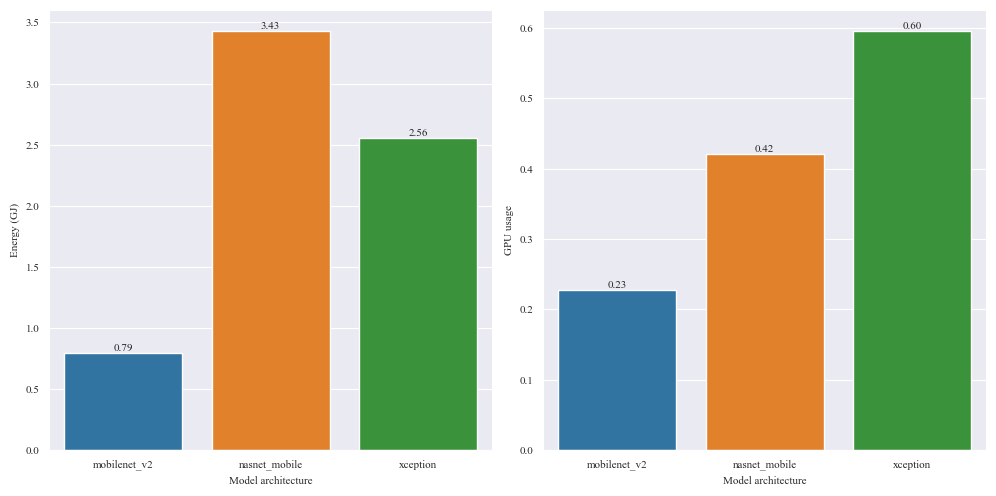

In [134]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
cloud_df = analysis_df.query("`training strategy` == 'cloud'")
ax = sns.barplot(cloud_df, x="architecture", y="energy", errorbar=None, estimator="median", ax=ax1)
ax.yaxis.grid(True)
ax.set_xlabel("Model architecture")
ax.set_ylabel("Energy (GJ)")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

ax = sns.barplot(cloud_df, x="architecture", y="gpu_usage", errorbar=None, estimator="median", ax=ax2)
ax.yaxis.grid(True)
ax.set_xlabel("Model architecture")
ax.set_ylabel("GPU usage")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "cloud-energy-comparison.eps"))

In [ ]:
_, ax = barplot(
    analysis_df.query("`training strategy` != 'local-v2'"),
    x="architecture",
    y="energy",
    hue="training strategy",
    estimator="median",
    xlabel="Model architecture",
    ylabel="Energy (GJ)",
    barlabel=True,
)
ax.legend(title="Training strategy")
if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "energy-comparison.eps"))

In [ ]:
_, ax = barplot(
    analysis_df.query("`training strategy` != 'local-v2'"),
    x="architecture",
    y="accuracy",
    xlabel="Model architecture",
    ylabel="Accuracy",
    estimator="median",
    barlabel=True,
)
if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "accuracy-comparison.eps"))

#### Test normality and variance homogeneity for the dependent variables
##### Temperature
###### Cloud

In [ ]:
cloud_mobilenet = analysis_df.query(
    "`training strategy` == 'cloud' & `architecture` == 'mobilenet_v2'"
)
local_mobilenet = analysis_df.query(
    "`training strategy` == 'local' & `architecture` == 'mobilenet_v2'"
)
cloud_nasnet = analysis_df.query(
    "`training strategy` == 'cloud' & `architecture` == 'nasnet_mobile'"
)
local_nasnet = analysis_df.query(
    "`training strategy` == 'local' & `architecture` == 'nasnet_mobile'"
)
cloud_xception = analysis_df.query(
    "`training strategy` == 'cloud' & `architecture` == 'xception'"
)

Now we test the normality and homogeneity of variance of the temperature in the cloud architecture. The results show that the NASNet measurements of temperature are not normally distributed. Also, the homogeneity of variance is not met.

In [ ]:
test_assumptions(
    cloud_mobilenet["temperature"],
    cloud_nasnet["temperature"],
    cloud_xception["temperature"],
)

If we look at the boxplots, we observe that the NASNet architecture has some extreme outliers. Thus, we proceed to remove them.

In [ ]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet, cloud_xception]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="cloud-temp-boxplot.eps",
)

Looking at the temperatures from the NASNet architecture we observe that most of the values fall between 54 and 55 Celsius. Seeing this, we decide to remove the four samples that exceed this range.

In [ ]:
print(cloud_nasnet["temperature"].describe())
cloud_nasnet["temperature"].sort_values(ascending=False)

In [ ]:
cloud_nasnet_no_temp_outliers = cloud_nasnet.query(f"temperature < 56")
print("Samples removed:", 30 - cloud_nasnet_no_temp_outliers.shape[0])

If we repeat the assumption check without the outliers, we see how the three goups are now normally distributed. However, we still do not met the homogeneity of variance assumption.

In [ ]:
test_assumptions(
    cloud_mobilenet["temperature"],
    cloud_nasnet_no_temp_outliers["temperature"],
    cloud_xception["temperature"],
)

In [ ]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="cloud-temp-boxplot-noout.eps",
)

###### Local
Now, we check the assumptions for the local training architecture. We observe that the MobileNet V2 architecture does not follow a normal distribution. Also, the homogeneity of variance assumption is met in this case. In this case, we do not observe any outliers in the data.

In [ ]:
test_assumptions(local_mobilenet.temperature, local_nasnet.temperature)

In [ ]:
boxplot(
    pd.concat([local_mobilenet, local_nasnet]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname="local-temp-boxplot.eps",
)

##### Impact of temperature on energy consumption

In [ ]:
temp_vs_energy_df = pd.concat(
    [cloud_mobilenet, cloud_nasnet, cloud_xception, local_mobilenet, local_nasnet]
)

temp_vs_energy_df["combinations"] = (
    temp_vs_energy_df["training strategy"] + " " + temp_vs_energy_df["architecture"]
)

In [ ]:
_, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.scatterplot(
    temp_vs_energy_df, x="temperature", y="energy", ax=axes, hue="combinations"
)
ax.set_title("Temperature vs. Energy")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("Energy (GJ)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-energy-scatter.eps"))

In [ ]:
cloud_df = temp_vs_energy_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["energy"])

In [ ]:
local_df = temp_vs_energy_df.query("`training strategy` == 'local'")
test_assumptions(local_df["temperature"], local_df["energy"])

In [ ]:
boxplot(
    temp_vs_energy_df,
    x="training strategy",
    y="temperature",
    xlabel="Training strategy",
    ylabel="Temperature (Celsius)",
    figname="temperature-boxplot.eps",
)

In [ ]:
boxplot(
    temp_vs_energy_df,
    x="training strategy",
    y="energy",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
    figname="energy-boxplot.eps",
)

In [ ]:
no_outliers_df = pd.concat(
    [cloud_df.sort_values("energy", ascending=True).iloc[:-1], local_df]
)
boxplot(
    no_outliers_df,
    x="training strategy",
    y="energy",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
)

In [ ]:
cloud_df = no_outliers_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["energy"])

In [ ]:
local_df = no_outliers_df.query("`training strategy` == 'local'")
test_assumptions(local_df["temperature"], local_df["energy"])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = no_outliers_df.query("`training strategy` == @strategy")[
        ["temperature", "energy"]
    ]
    corr = data.corr("spearman")
    print(strategy)
    print(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training strategy: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-energy-correlation.eps"))

##### Impact of temperature on GPU usage

In [ ]:
temp_vs_gpu_usage_df = pd.concat(
    [cloud_mobilenet, cloud_nasnet, cloud_xception, local_mobilenet, local_nasnet]
)

temp_vs_gpu_usage_df["combinations"] = (
    temp_vs_gpu_usage_df["training strategy"]
    + " "
    + temp_vs_gpu_usage_df["architecture"]
)

In [ ]:
_, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = sns.scatterplot(
    temp_vs_gpu_usage_df, x="temperature", y="gpu_usage", ax=axes, hue="combinations"
)
ax.set_title("Temperature vs. GPU usage")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("GPU usage")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-gpu_usage-scatter.eps"))

In [ ]:
cloud_df = temp_vs_gpu_usage_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["gpu_usage"])

In [ ]:
local_df = temp_vs_gpu_usage_df.query("`training strategy` == 'local'")
test_assumptions(local_df["temperature"], local_df["gpu_usage"])

In [ ]:
boxplot(
    temp_vs_gpu_usage_df,
    x="training strategy",
    y="gpu_usage",
    xlabel="Training strategy",
    ylabel="GPU usage",
    figname="gpu_usage-boxplot.eps",
)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = temp_vs_gpu_usage_df.query("`training strategy` == @strategy")[
        ["temperature", "gpu_usage"]
    ]
    corr = data.corr("spearman")
    print(strategy)
    print(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training strategy: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "temperature-gpu_usage-correlation.eps"))

##### Energy
###### Cloud
We proceed to check if the assumptions are met for the energy measurements.

The results of the tests show that the NASNet is the only one not following a normal distribution. Moreover, we observe that the homogeneity of variance is not met in this case.

In [ ]:
test_assumptions(
    cloud_mobilenet.energy, cloud_nasnet_no_temp_outliers.energy, cloud_xception.energy
)

As it occurred with the temperature, we observe some extreme outliers. In this case in the NASNet and Xception architectures.

In [ ]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception]),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (GJ)",
    figname="cloud-energy-boxplot.eps",
)

We proceed to remove the outliers from the energy measurements.

In [ ]:
cloud_xception_no_energy_outliers = cloud_xception.sort_values(by="energy").iloc[:-4]
print("Xception samples removed:", 30 - cloud_xception_no_energy_outliers.shape[0])

After removing the outliers, we see how the normality assumption is met for all the architectures. However, we still do not met the homogeneity of variance assumption.

In [ ]:
test_assumptions(
    cloud_mobilenet.energy,
    cloud_nasnet_no_temp_outliers.energy,
    cloud_xception_no_energy_outliers.energy,
)

In [ ]:
boxplot(
    pd.concat(
        [
            cloud_mobilenet,
            cloud_nasnet_no_temp_outliers,
            cloud_xception_no_energy_outliers,
        ]
    ),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (GJ)",
    figname="cloud-energy-boxplot-noout.eps",
)

###### Local vs. Cloud
For the Local vs. Cloud analysis of energy, we see that we only meet the normality assumption. Also, looking at the boxplot, we see that there are no outliers.

In [ ]:
test_assumptions(local_nasnet.energy, cloud_nasnet_no_temp_outliers.energy)

In [ ]:
boxplot(
    pd.concat([local_nasnet, cloud_nasnet_no_temp_outliers]),
    x="training strategy",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (GJ)",
    figname="local-vs-cloud-energy-boxplot.eps",
)

##### GPU usage
###### Cloud

For the GPU usage we observe that none of the assumptions are met in the cloud training architecture. Also, we observe the presence of outliers in the NASNet measurements.

In [ ]:
test_assumptions(
    cloud_mobilenet.gpu_usage,
    cloud_nasnet_no_temp_outliers.gpu_usage,
    cloud_xception.gpu_usage,
)

In [ ]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception]),
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage",
    figname="cloud-gpu_usage-boxplot.eps",
)

In [ ]:
cloud_nasnet_no_gpu_outliers = cloud_nasnet_no_temp_outliers.sort_values(
    by="gpu_usage", ascending=True
).iloc[:-2]
print("NASNet samples removed:", 30 - cloud_nasnet_no_gpu_outliers.shape[0])
cloud_mobilenet_no_gpu_outliers = cloud_mobilenet.sort_values(
    by="gpu_usage", ascending=True
).iloc[1:]
print("MobileNet samples removed:", 30 - cloud_mobilenet_no_gpu_outliers.shape[0])

In [ ]:
test_assumptions(
    cloud_mobilenet_no_gpu_outliers.gpu_usage,
    cloud_nasnet_no_gpu_outliers.gpu_usage,
    cloud_xception.gpu_usage,
)

In [ ]:
boxplot(
    pd.concat(
        [cloud_mobilenet_no_gpu_outliers, cloud_nasnet_no_gpu_outliers, cloud_xception]
    ),
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage",
)

###### Local vs. Cloud

The results on the local architecture show that we met the normality assumptions but not the equality of variances.

In [ ]:
test_assumptions(local_nasnet.gpu_usage, cloud_nasnet_no_gpu_outliers.gpu_usage)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y=local_nasnet.gpu_usage, ax=ax1)
ax1.set_ylabel("GPU usage")
ax1.set_title("Training strategy: Local")

sns.boxplot(y=cloud_nasnet_no_gpu_outliers.gpu_usage, ax=ax2)
ax2.set_ylabel("GPU usage")
ax2.set_title("Training strategy: Cloud")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "cloud-local-gpu_usage-boxplot.eps"))

##### Accuracy
###### Cloud
When we check the assumptions for the binary accuracy, we see that MobileNet V2 does not follow a normal distribution. Also, we reject the null hypothesis of equal variances.

In [ ]:
test_assumptions(
    cloud_mobilenet.accuracy, cloud_nasnet.accuracy, cloud_xception.accuracy
)

Looking at the boxplot, we see that the MobileNet V2 architecture has some extreme outliers. Thus, we proceed to remove them.

In [ ]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet, cloud_xception]),
    x="architecture",
    y="accuracy",
    xlabel="Model architecture",
    ylabel="Binary accuracy",
    figname="cloud-accuracy-boxplot.eps",
)

In [ ]:
cloud_mobilenet_no_accuracy_outliers = cloud_mobilenet.sort_values(
    "accuracy", ascending=True
).iloc[2:]
print("MobileNet samples removed:", 30 - cloud_mobilenet_no_accuracy_outliers.shape[0])
cloud_nasnet_no_accuracy_outliers = cloud_nasnet.sort_values(
    "accuracy", ascending=True
).iloc[1:]
print("NASNet samples removed:", 30 - cloud_nasnet_no_accuracy_outliers.shape[0])

In [ ]:
test_assumptions(
    cloud_mobilenet_no_accuracy_outliers.accuracy,
    cloud_nasnet_no_accuracy_outliers.accuracy,
    cloud_xception.accuracy,
)

In [ ]:
boxplot(
    pd.concat(
        [
            cloud_mobilenet_no_accuracy_outliers,
            cloud_nasnet_no_accuracy_outliers,
            cloud_xception,
        ]
    ),
    x="architecture",
    y="accuracy",
    xlabel="Model architecture",
    ylabel="Binary accuracy",
)

#### FLOPs vs. Energy and GPU usage

In [ ]:
flops_vs_energy_df = pd.concat(
    [
        cloud_mobilenet_no_gpu_outliers,
        cloud_nasnet_no_temp_outliers,
        cloud_xception_no_energy_outliers,
        local_mobilenet,
        local_nasnet,
    ]
)

flops_vs_energy_df["combinations"] = (
    flops_vs_energy_df["training strategy"] + " " + flops_vs_energy_df["architecture"]
)

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))
cloud = flops_vs_energy_df.query("`training strategy` == 'cloud'")
cloud.loc[:, "GFLOPs"] = cloud["GFLOPs"].round(3)
ax = sns.pointplot(
    cloud,
    x="GFLOPs",
    y="energy",
    ax=axes[0],
    hue="architecture",
    errorbar=("ci", 95),
    errwidth=1,
    capsize=0.05,
)
ax.set_title("GFLOPs vs. Energy")
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Energy (GJ)")

ax = sns.pointplot(
    cloud,
    x="GFLOPs",
    y="gpu_usage",
    ax=axes[1],
    hue="architecture",
    errorbar=("ci", 95),
    errwidth=1,
    capsize=0.05,
)
ax.set_title("GFLOPs vs. GPU usage")
ax.set_xlabel("GFLOPs")
ax.set_ylabel("GPU usage")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "flops-vs-energy-and-gpu-usage.eps"))

In [ ]:
cloud_df = flops_vs_energy_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["GFLOPs"], cloud_df["energy"])

In [ ]:
local_df = flops_vs_energy_df.query("`training strategy` == 'local'")
test_assumptions(local_df["GFLOPs"], local_df["energy"])

In [ ]:
boxplot(
    flops_vs_energy_df,
    x="training strategy",
    y="GFLOPs",
    xlabel="Training strategy",
    ylabel="GFLOPs",
    figname="flops-boxplot.eps",
)

In [ ]:
boxplot(
    flops_vs_energy_df,
    x="training strategy",
    y="energy",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
    figname="energy-boxplot.eps",
)

In [ ]:
no_outliers_df = pd.concat(
    [cloud_df.sort_values("energy", ascending=True).iloc[:-1], local_df]
)
boxplot(
    no_outliers_df,
    x="training strategy",
    y="energy",
    xlabel="Training strategy",
    ylabel="Energy (GJ)",
)

In [ ]:
cloud_df = no_outliers_df.query("`training strategy` == 'cloud'")
test_assumptions(cloud_df["GFLOPs"], cloud_df["energy"])

In [ ]:
local_df = no_outliers_df.query("`training strategy` == 'local'")
test_assumptions(local_df["GFLOPs"], local_df["energy"])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

data = cloud_df[["GFLOPs", "energy"]]
corr = data.corr("spearman")
print("Energy")
print(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[0], cmap="coolwarm")
ax.set_title(f"FLOPs vs. Energy")

data = cloud_df[["GFLOPs", "gpu_usage"]]
corr = data.corr("spearman")
print("GPU usage")
print(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[1], cmap="coolwarm")
ax.set_title(f"FLOPs vs. GPU usage")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, "flops-energy-gpu_usage-correlation.eps"))

## Statistical significance analysis

Remove units from column names to ease working with them.

### RQ1

#### RQ1.1

##### One-Way ANOVA test

In [ ]:
rq11_df = pd.concat(
    [cloud_mobilenet, cloud_nasnet_no_temp_outliers, cloud_xception_no_energy_outliers]
)

In [ ]:
model = ols("energy ~ C(architecture)", data=rq11_df).fit()
aov_table = sm.stats.anova_lm(model, typ=1)
aov_table

##### Tukey post-hoc test

In [ ]:
comp = mc.MultiComparison(rq11_df["energy"], rq11_df["architecture"])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

##### Kruskal-Wallis test

In [ ]:
mobilenet_v2 = rq11_df["energy"][rq11_df["architecture"] == "mobilenet_v2"]
nasnet_mobile = rq11_df["energy"][rq11_df["architecture"] == "nasnet_mobile"]
xception = rq11_df["energy"][rq11_df["architecture"] == "xception"]
stats.kruskal(mobilenet_v2, nasnet_mobile, xception)

##### Dunn's test

In [ ]:
data = [mobilenet_v2, nasnet_mobile, xception]
p_values = sp.posthoc_dunn(data, p_adjust="bonferroni")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

#### RQ1.2

##### One-Way ANOVA test

In [ ]:
rq12_df = pd.concat(
    [cloud_mobilenet_no_gpu_outliers, cloud_nasnet_no_gpu_outliers, cloud_xception]
)

In [ ]:
model = ols("gpu_usage ~ C(architecture)", data=rq12_df).fit()
aov_table = sm.stats.anova_lm(model, typ=1)
aov_table

##### Tukey post-hoc test

In [ ]:
comp = mc.MultiComparison(rq11_df["gpu_usage"], rq11_df["architecture"])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

##### Kruskal-Wallis test

In [ ]:
mobilenet_v2 = rq12_df["gpu_usage"][rq12_df["architecture"] == "mobilenet_v2"]
nasnet_mobile = rq12_df["gpu_usage"][rq12_df["architecture"] == "nasnet_mobile"]
xception = rq12_df["gpu_usage"][rq12_df["architecture"] == "xception"]
stats.kruskal(mobilenet_v2, nasnet_mobile, xception)

##### Dunn's test

In [ ]:
data = [mobilenet_v2, nasnet_mobile, xception]
p_values = sp.posthoc_dunn(data, p_adjust="bonferroni")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

#### RQ1.3

In [ ]:
rq13_df = pd.concat(
    [
        cloud_mobilenet_no_accuracy_outliers,
        cloud_nasnet_no_accuracy_outliers,
        cloud_xception,
    ]
)

##### One-Way ANOVA test

In [ ]:
model = ols("accuracy ~ C(architecture)", data=rq13_df).fit()
aov_table = sm.stats.anova_lm(model, typ=1)
aov_table

##### Tukey post-hoc test

In [ ]:
comp = mc.MultiComparison(rq13_df["accuracy"], rq13_df["architecture"])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

##### Kruskal-Wallis test

In [ ]:
mobilenet_v2 = rq13_df["accuracy"][rq13_df["architecture"] == "mobilenet_v2"]
nasnet_mobile = rq13_df["accuracy"][rq13_df["architecture"] == "nasnet_mobile"]
xception = rq13_df["accuracy"][rq13_df["architecture"] == "xception"]
stats.kruskal(mobilenet_v2, nasnet_mobile, xception)

##### Dunn's test

In [ ]:
data = [mobilenet_v2, nasnet_mobile, xception]
p_values = sp.posthoc_dunn(data, p_adjust="bonferroni")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

### RQ2

#### RQ2.1

In [ ]:
rq21_df = pd.concat([local_nasnet, cloud_nasnet_no_temp_outliers])

In [ ]:
local = rq21_df.energy[rq21_df["training strategy"] == "local"]
cloud = rq21_df.energy[rq21_df["training strategy"] == "cloud"]

##### Independent t-test

In [ ]:
stats.ttest_ind(local, cloud)

##### Cohen's d

In [ ]:
def cohend(group1, group2):
    # calculate the size of samples
    n1, n2 = len(group1), len(group2)

    # calculate the variance of the samples
    s1, s2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = np.mean(group1), np.mean(group2)

    # return effect size
    return (u1 - u2) / s

In [ ]:
cohend(local, cloud)

##### Mann-Whitney U test

In [ ]:
stats.mannwhitneyu(local, cloud, alternative="two-sided")

##### Cliff's delta

In [ ]:
cliffs_delta(local, cloud)

#### RQ2.2

In [ ]:
rq22_df = pd.concat([local_nasnet, cloud_nasnet_no_gpu_outliers])

In [ ]:
local = rq22_df.gpu_usage[rq22_df["training strategy"] == "local"]
cloud = rq22_df.gpu_usage[rq22_df["training strategy"] == "cloud"]

##### Independent t-test

In [ ]:
stats.ttest_ind(local, cloud)

##### Cohen's d

In [ ]:
cohend(local, cloud)

##### Mann-Whitney U test

In [ ]:
stats.mannwhitneyu(local, cloud, alternative="two-sided")

##### Cliff's delta

In [ ]:
cliffs_delta(local, cloud)
